#Classify
Project ini merupakan bagian dari aplikasi Classify. Program yang tersaji digunakan untuk melatih model dari dataset yang telah kami buat melalui pengumpulan sampel wajah dari beberapa anggoota kelompok kama.

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from mtcnn import MTCNN
import cv2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Inisialisasi MTCNN detector
detector = MTCNN()

# Fungsi untuk memproses satu gambar, mendeteksi wajah dan mengembalikan hasil deteksi
def process_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Gambar tidak dapat dibaca: {img_path}")
        return None

    # Deteksi wajah
    faces = detector.detect_faces(img)
    face_images = []

    for face in faces:
        x, y, width, height = face['box']
        face_img = img[y:y + height, x:x + width]
        # Resize dan normalisasi gambar wajah
        face_img = cv2.resize(face_img, (150, 150)) / 255.0
        face_images.append(face_img)

    return face_images

# Fungsi untuk mendeteksi dan menyimpan wajah ke dalam batch secara paralel
def detect_and_store_faces_batch_parallel(input_dir, batch_size=100):
    detected_faces = []
    batch_counter = 0

    # Executor untuk parallel processing
    with ThreadPoolExecutor() as executor:
        future_to_image = {}

        # Iterasi melalui semua folder siswa di dalam folder train/test
        for student_folder in os.listdir(input_dir):
            student_path = os.path.join(input_dir, student_folder)

            # Iterasi melalui semua gambar di folder siswa
            for img_file in os.listdir(student_path):
                img_path = os.path.join(student_path, img_file)
                # Menjalankan process_image secara paralel
                future = executor.submit(process_image, img_path)
                future_to_image[future] = img_path

        # Mengumpulkan hasil dari proses paralel
        for future in future_to_image:
            result = future.result()
            if result is not None:
                detected_faces.extend(result)
                batch_counter += len(result)

            # Jika batch size sudah tercapai, keluarkan batch
            if batch_counter >= batch_size:
                yield detected_faces
                detected_faces = []  # Reset list untuk batch berikutnya
                batch_counter = 0

    # Keluarkan batch terakhir jika ada
    if detected_faces:
        yield detected_faces

# Folder input (train dan test)
train_dir = '/content/drive/MyDrive/dataset/train'
validation_dir = '/content/drive/MyDrive/dataset/validation'  # Pastikan ada folder validasi
test_dir = '/content/drive/MyDrive/dataset/test'  # Pastikan ada folder test

# Proses batch untuk deteksi wajah
detected_faces = []
for face_batch in detect_and_store_faces_batch_parallel(train_dir, batch_size=100):
    detected_faces.extend(face_batch)

# Konversi list detected_faces ke array numpy yang bisa digunakan oleh model
detected_faces = np.array(detected_faces)

print(f"Total wajah yang terdeteksi: {len(detected_faces)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
# Augmentasi dan normalisasi gambar untuk data train
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisasi
    rotation_range=20,      # Augmentasi rotasi
    width_shift_range=0.2,  # Augmentasi pergeseran lebar
    height_shift_range=0.2, # Augmentasi pergeseran tinggi
    shear_range=0.2,        # Augmentasi shearing
    zoom_range=0.2,         # Augmentasi zoom
    horizontal_flip=True,   # Membalikkan gambar secara horizontal
    fill_mode='nearest'     # Pengisian piksel setelah augmentasi
)

In [ ]:
# Normalisasi gambar untuk data test
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Data generator untuk train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Data generator untuk test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 550 images belonging to 6 classes.
Found 187 images belonging to 6 classes.


In [ ]:
# # Membangun model CNN
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(len(train_generator.class_indices), activation='softmax')  # Disesuaikan untuk multi-class
# ])

In [ ]:
# Menggunakan model ResNet50 pretrained
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Menambahkan layer fully connected di atasnya
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
# Membuat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Membekukan layer pretrained ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile model dengan optimizer Adam dan learning rate rendah
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.1868 - loss: 3.2248 - val_accuracy: 0.3102 - val_loss: 1.5074
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 393ms/step - accuracy: 0.4651 - loss: 1.4533 - val_accuracy: 0.7861 - val_loss: 0.8541
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.7455 - loss: 1.0162 - val_accuracy: 0.9465 - val_loss: 0.5318
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.8109 - loss: 0.7435 - val_accuracy: 0.9786 - val_loss: 0.3946
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.8312 - loss: 0.6381 - val_accuracy: 0.9626 - val_loss: 0.2454
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.8928 - loss: 0.4792 - val_accuracy: 0.9572 - val_loss: 0.2588
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.9007 - loss: 0.4536 - val_accuracy: 0.9626 - val_loss: 0.2023
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - accuracy: 0.9323 - loss: 0.3557 - val_accuracy: 0.9626 

In [ ]:
# Menyimpan model yang telah dilatih
model.save('/content/face_detection_resnet.h5')

In [ ]:
model.save('/content/classify_resnet.keras')

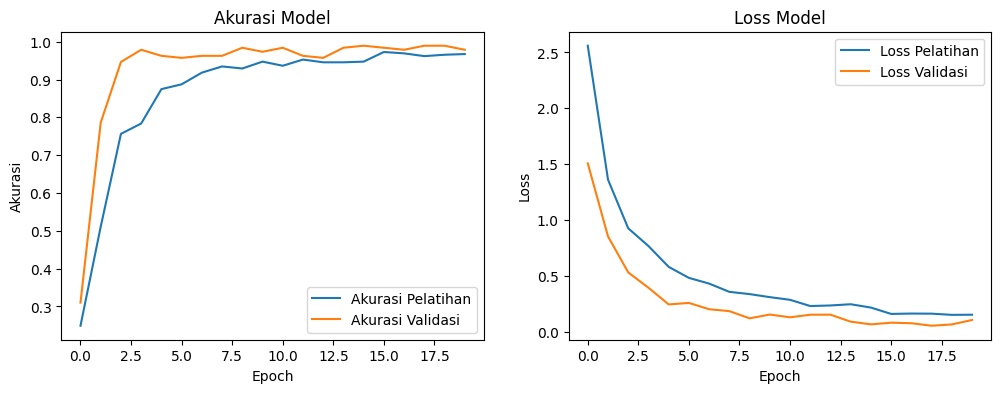

In [ ]:
# Visualisasi hasil pelatihan

# Misalkan history adalah hasil dari model.fit()
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Evaluasi akhir menggunakan data validation untuk mendapatkan nilai loss dan accuracy
final_loss, final_accuracy = model.evaluate(test_generator)
print(f'Final Loss: {final_loss}, Final Accuracy: {final_accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.9810 - loss: 0.0807
Final Loss: 0.054610032588243484, Final Accuracy: 0.9893048405647278


In [ ]:
# Buat generator untuk data test
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
# Buat generator untuk data test
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Folder test yang ada di Google Drive
    target_size=(224, 224),  # Ukuran gambar yang sesuai dengan model
    batch_size=32,  # Sesuaikan dengan ukuran batch yang diinginkan
    class_mode='categorical',  # Untuk multi-class classification
    shuffle=False  # Jangan di-shuffle supaya urutannya sesuai dengan prediksi
)

Found 187 images belonging to 6 classes.


In [ ]:
# Ambil label sebenarnya dari test_generator
y_test = test_generator.classes  # Ini akan memberikan label sebenarnya dari data test

In [ ]:
# Ambil prediksi dari model
test_predictions = model.predict(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 903ms/step


In [ ]:
# Ambil kelas prediksi
test_predicted_classes = np.argmax(test_predictions, axis=1)

In [ ]:
# Evaluasi akurasi
accuracy = np.mean(test_predicted_classes == y_test)
print(f'Akurasi pada data test: {accuracy * 100:.2f}%')

Akurasi pada data test: 98.93%


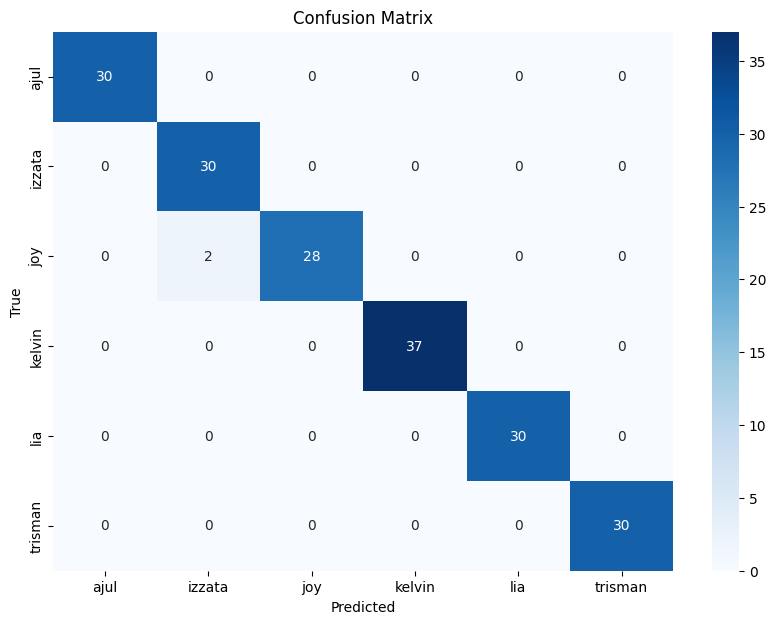

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print(classification_report(y_test, test_predicted_classes, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

        ajul       1.00      1.00      1.00        30
      izzata       0.94      1.00      0.97        30
         joy       1.00      0.93      0.97        30
      kelvin       1.00      1.00      1.00        37
         lia       1.00      1.00      1.00        30
     trisman       1.00      1.00      1.00        30

    accuracy                           0.99       187
   macro avg       0.99      0.99      0.99       187
weighted avg       0.99      0.99      0.99       187



In [ ]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

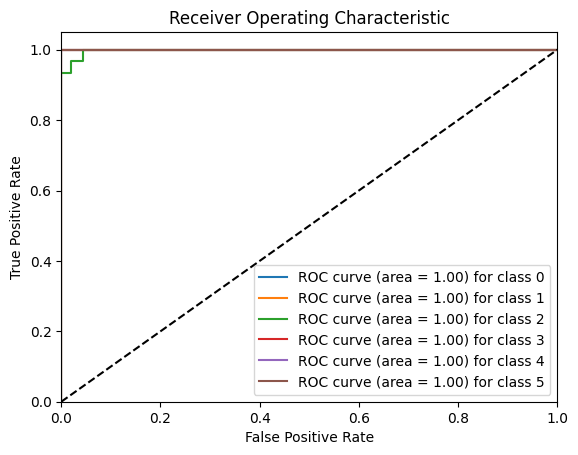

In [ ]:
# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()